In [ ]:


from transformers import AutoFeatureExtractor, SwinForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

data_dir = "/content/drive/My Drive/YapayZekaRessam/"


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root=data_dir + "train", transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir + "val", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


In [ ]:

feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/swin-base-patch4-window7-224')
model = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224', num_labels=10, ignore_mismatched_sizes=True) # Added ignore_mismatched_sizes=True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([10, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_time = time.time()

def train_epoch(model, dataloaders, dataset_sizes, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)


        if (i + 1) % 10 == 0:
            batch_accuracy = torch.sum(preds == labels.data).item() / labels.size(0)
            print(f'Batch {i+1}/{len(dataloaders["train"])}: Train Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train'] * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch Train Loss: {epoch_loss:.4f}, Epoch Train Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloaders, dataset_sizes, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)


        if (i + 1) % 10 == 0:
            batch_accuracy = torch.sum(preds == labels.data).item() / labels.size(0)
            print(f'Batch {i+1}/{len(dataloaders["val"])}: Val Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val'] * 100

    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f'Epoch Val Loss: {epoch_loss:.4f}, Epoch Val Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model, dataloaders, dataset_sizes, optimizer, criterion, device)
    val_loss, val_acc = validate_epoch(model, dataloaders, dataset_sizes, criterion, device)

training_time = time.time() - start_time
print(f'Total Training Time: {training_time:.2f} seconds')

print('Eğitim tamamlandı')


Epoch 1/2
----------
Batch 10/425: Train Loss: 0.8022, Batch Accuracy: 71.88%
Batch 20/425: Train Loss: 0.3972, Batch Accuracy: 88.28%
Batch 30/425: Train Loss: 0.4177, Batch Accuracy: 88.28%
Batch 40/425: Train Loss: 0.3194, Batch Accuracy: 89.06%
Batch 50/425: Train Loss: 0.4584, Batch Accuracy: 83.59%
Batch 60/425: Train Loss: 0.1655, Batch Accuracy: 96.09%
Batch 70/425: Train Loss: 0.1088, Batch Accuracy: 98.44%
Batch 80/425: Train Loss: 0.1893, Batch Accuracy: 94.53%
Batch 90/425: Train Loss: 0.2379, Batch Accuracy: 91.41%
Batch 100/425: Train Loss: 0.1914, Batch Accuracy: 92.19%
Batch 110/425: Train Loss: 0.1322, Batch Accuracy: 95.31%
Batch 120/425: Train Loss: 0.1670, Batch Accuracy: 95.31%
Batch 130/425: Train Loss: 0.1464, Batch Accuracy: 95.31%
Batch 140/425: Train Loss: 0.0495, Batch Accuracy: 99.22%
Batch 150/425: Train Loss: 0.0805, Batch Accuracy: 96.88%
Batch 160/425: Train Loss: 0.0484, Batch Accuracy: 98.44%
Batch 170/425: Train Loss: 0.0729, Batch Accuracy: 97.66%
Ba

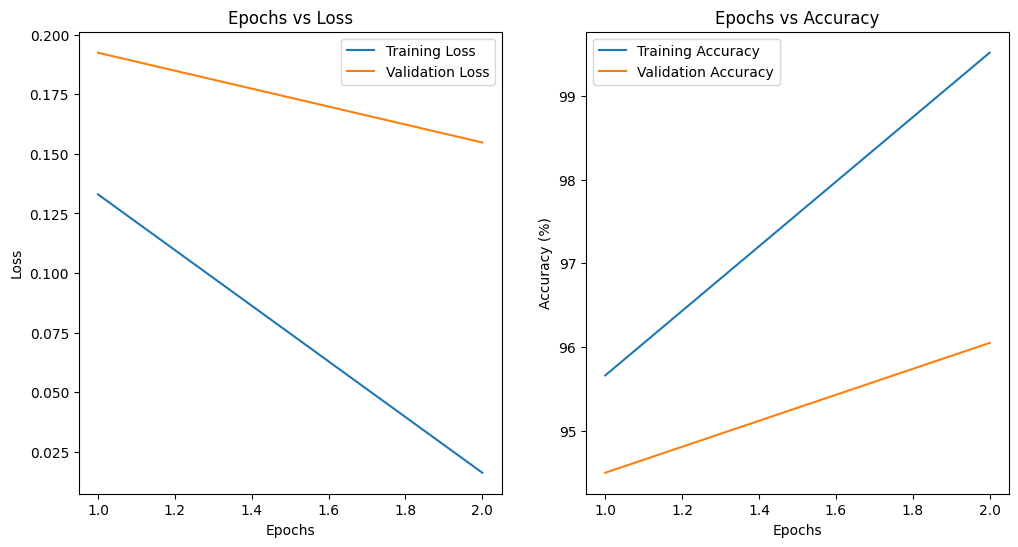

In [ ]:

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, [acc.cpu().numpy() for acc in train_accuracies], label='Training Accuracy')
plt.plot(epochs, [acc.cpu().numpy() for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Epochs vs Accuracy')
plt.legend()

plt.show()

In [ ]:

import os
save_path = "/content/drive/My Drive/SwinModel3/model"
if not os.path.exists(save_path):
    os.makedirs(save_path)


model.save_pretrained(save_path)
feature_extractor.save_pretrained(save_path)


training_data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'training_time': training_time
}

import pickle
with open(os.path.join(save_path, 'training_data.pkl'), 'wb') as f:
    pickle.dump(training_data, f)

print("Model, özellik çıkarıcı ve eğitim verileri başarıyla kaydedildi!")


Model, özellik çıkarıcı ve eğitim verileri başarıyla kaydedildi!


test


In [ ]:


from transformers import AutoFeatureExtractor, SwinForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import time

# Drive'a bağlanın
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

load_path = "/content/drive/My Drive/SwinModel3/model"
model = SwinForImageClassification.from_pretrained(load_path)
feature_extractor = AutoFeatureExtractor.from_pretrained(load_path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


import pickle
with open(os.path.join(load_path, 'training_data.pkl'), 'rb') as f:
    training_data = pickle.load(f)

train_losses = training_data['train_losses']
val_losses = training_data['val_losses']
train_accuracies = training_data['train_accuracies']
val_accuracies = training_data['val_accuracies']
training_time = training_data['training_time']

print("Model ve eğitim verileri başarıyla yüklendi!")


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model ve eğitim verileri başarıyla yüklendi!


In [ ]:

test_data_dir = "/content/drive/My Drive/YapayZekaRessam/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

confMatrix = confusion_matrix(gercek, tahmin)

def hesaplaSpecificity(confMatrix):
    specificitySinifBasina = []
    for i in range(len(confMatrix)):
        tn = confMatrix.sum() - (confMatrix[i, :].sum() + confMatrix[:, i].sum() - confMatrix[i, i])
        fp = confMatrix[:, i].sum() - confMatrix[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificitySinifBasina.append(specificity)
    return np.mean(specificitySinifBasina)

specificity = hesaplaSpecificity(confMatrix)

accuracy = accuracy_score(gercek, tahmin)
precision = precision_score(gercek, tahmin, average='weighted')
recall = recall_score(gercek, tahmin, average='weighted')
fScore = f1_score(gercek, tahmin, average='weighted')

olasilik = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).logits
        olasiliklar = torch.softmax(outputs, dim=1)
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
auc = roc_auc_score(gercekOneHot, np.array(olasilik), average='weighted', multi_class='ovr')

print(f"Accuracy: %{accuracy * 100:.2f}")
print(f"Precision: %{precision * 100:.2f}")
print(f"Recall: %{recall * 100:.2f}")
print(f"Specificity: %{specificity * 100:.2f}")
print(f"F-Score: %{fScore * 100:.2f}")
print(f"AUC: %{auc * 100:.2f}")


Accuracy: %96.24
Precision: %96.26
Recall: %96.24
Specificity: %99.58
F-Score: %96.22
AUC: %99.88


In [ ]:
def cikarimHesap(model, test_loader, device):
    model.eval()
    baslangicZamani = time.time()

    with torch.no_grad():
        for gorseller, _ in test_loader:
            gorseller = gorseller.to(device)
            cikti = model(gorseller)

    bitisZamani = time.time()
    cikarmaZamani = bitisZamani - baslangicZamani
    return cikarmaZamani

cikarmaZamani = cikarimHesap(model, test_loader, device)
print(f'Çıkarım Zamanı: {cikarmaZamani:.2f} saniye')


Çıkarım Zamanı: 6.54 saniye


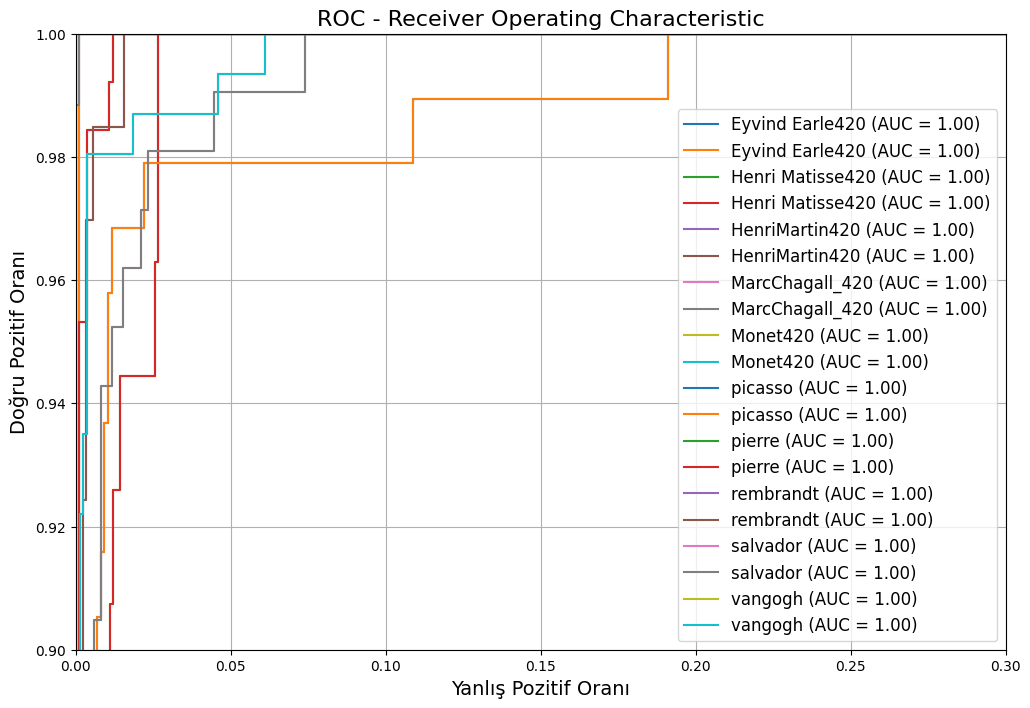

In [ ]:


from transformers import AutoFeatureExtractor, SwinForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import time


from sklearn.metrics import auc

def ROCEgrisi(gercek, olasilik, sinifAdlari):
    plt.figure(figsize=(12, 8))

    for i, sinifAdi in enumerate(sinifAdlari):
        fpr, tpr, _ = roc_curve(gercek[:, i], olasilik[:, i])

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{sinifAdi} (AUC = {roc_auc:.2f})')
        plt.plot(fpr, tpr, label=f'{sinifAdi} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 0.3])
    plt.ylim([0.9, 1.0])
    plt.xlabel('Yanlış Pozitif Oranı', fontsize=14)
    plt.ylabel('Doğru Pozitif Oranı', fontsize=14)
    plt.title('ROC - Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc='lower right', prop={'size': 12})
    plt.grid(True)
    plt.show()

gercek = []
olasilik = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        olasiliklar = torch.softmax(outputs, dim=1)

        gercek.extend(labels.cpu().numpy())
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
olasilik = np.array(olasilik)

sinifAdlari = test_dataset.classes

ROCEgrisi(gercekOneHot, olasilik, sinifAdlari)


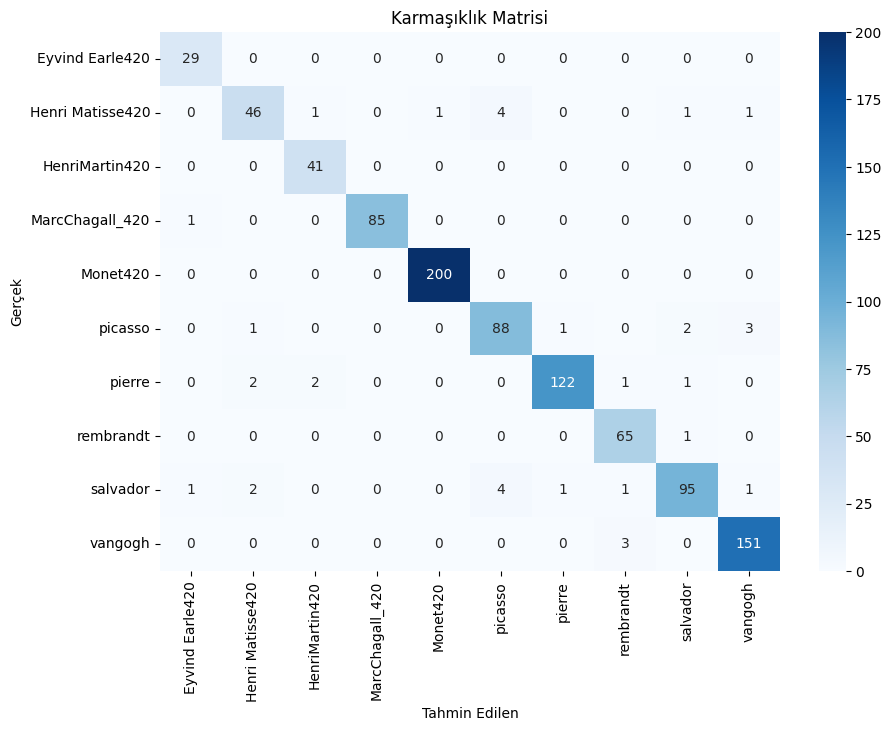

In [ ]:
def karmasiklikMatris(gercek, tahmin, sinifAdlari):
    confMatrix = confusion_matrix(gercek, tahmin)

    plt.figure(figsize=(10, 7))
    sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=sinifAdlari, yticklabels=sinifAdlari)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Karmaşıklık Matrisi')
    plt.show()

gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

sinifAdlari = test_dataset.classes

karmasiklikMatris(gercek, tahmin, sinifAdlari)


In [ ]:

model.eval()
correct = 0
total = 0

gercek = []
tahmin = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            print(f"Resim: {test_dataset.imgs[total - len(labels) + i][0]}")
            print(f"Gerçek Etiket: {test_dataset.classes[labels[i]]}, Tahmin Edilen Etiket: {test_dataset.classes[predicted[i]]}")
            print("-" * 50)

accuracy = 100 * correct / total
print(f"Test Accuracy: %{accuracy:.2f}")


Resim: /content/drive/My Drive/YapayZekaRessam/test/Eyvind Earle420/black-evergreen-forest-1981.jpg!Large.jpg
Gerçek Etiket: Eyvind Earle420, Tahmin Edilen Etiket: Eyvind Earle420
--------------------------------------------------
Resim: /content/drive/My Drive/YapayZekaRessam/test/Eyvind Earle420/blue-pine-1980.jpg!Large.jpg
Gerçek Etiket: Eyvind Earle420, Tahmin Edilen Etiket: Eyvind Earle420
--------------------------------------------------
Resim: /content/drive/My Drive/YapayZekaRessam/test/Eyvind Earle420/brown-tree-1974.jpg!Large.jpg
Gerçek Etiket: Eyvind Earle420, Tahmin Edilen Etiket: Eyvind Earle420
--------------------------------------------------
Resim: /content/drive/My Drive/YapayZekaRessam/test/Eyvind Earle420/california-landscape-1966.jpg!Large.jpg
Gerçek Etiket: Eyvind Earle420, Tahmin Edilen Etiket: Eyvind Earle420
--------------------------------------------------
Resim: /content/drive/My Drive/YapayZekaRessam/test/Eyvind Earle420/crimson-eucalyptus-1998.jpg!Large.j